## Skip this part and start reading from "Noise analysis".

First, import the data from the CSV file and create an integer array from it.

In [529]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
with open("new_measurements.csv") as csvfile:
    csv_reader = csv.reader(csvfile, csv.QUOTE_MINIMAL, delimiter=",")
    next(csv_reader)  # skip the header row
    rows = []
    for row in csv_reader:
        rows.append(row)
    
data = np.asarray(rows, dtype=np.int)

Now that we have all the data, we only need specific rows for each confidence ellipse.
We have five possible X true values: -1230, -650, 0, 650, 1230.
So let's write a function that takes one of the values as an input and outputs all the corresponding X and Z errors.

In [6]:
def get_x_and_z_errors(data, x_true_min, x_true_max=None):
    output = []
    if x_true_max == None:
        x_true_max = x_true_min
    filtered_array = data[np.where(np.logical_and(data[:, 1] <= x_true_max, data[:, 1] >= x_true_min))]
    
    return filtered_array[:, 4:7:2], sorted(set(filtered_array[:, 3]))

x_value_min = -1230
x_value_max = 1230
x_and_z_errors, z_values = get_x_and_z_errors(data, x_value_min, x_value_max)

This is a more general function to extract different columns from the data.

In [7]:
def get_columns(data, list_of_columns):
    return data[:, list_of_columns]

The following code is from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html.

In [464]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, ax, label=True):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax, alpha=w * w_factor)

## Noise analysis

First a GMM with 5 clusters of Z error vs X error.

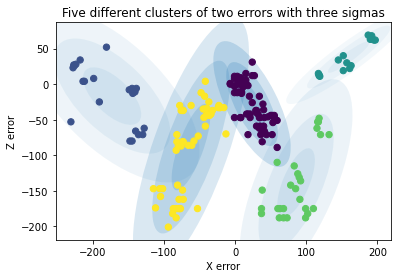

In [465]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("X error")
ax.set_ylabel("Z error")
ax.set_title("Five different clusters of two errors with three sigmas")
        
gmm = GaussianMixture(n_components=5, random_state=42)
plot_gmm(gmm, x_and_z_errors, ax)
plt.show()

This clustering of the two different errors against each other does not seem to be very useful in estimating the distribution of the position of an object based on the observed value, as those data points are not as well correlated as the "error vs ground truth" as shown below:

The following is a cluster fitted to X error vs X true.
In my opinion, this provides a lot of value, as it characterizes how the error is linear in nature and it also shows the distribution of the error.

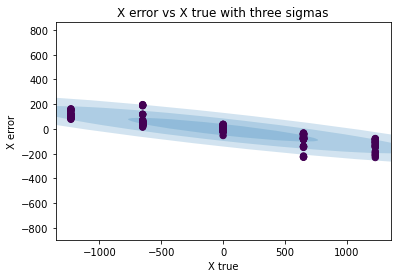

In [10]:
x_true_and_x_error = get_columns(data, [1, 4])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("X true")
ax.set_ylabel("X error")
ax.set_title("X error vs X true with three sigmas")
        
gmm = GaussianMixture(n_components=1, random_state=1)
plot_gmm(gmm, x_true_and_x_error, ax)
plt.show()

Now, a distribution of Z error vs Z true, which again characterizes the noise pretty well.
This could actually be described using more than one cluster, for the sake of later getting more accurate samples from the distribution (density estimation). For this reason, a graph with three clusters is also shown below.

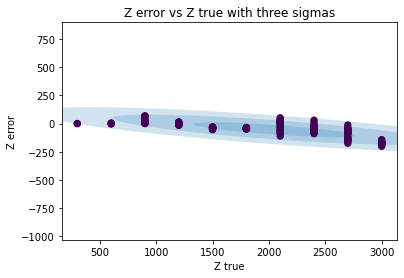

In [11]:
z_true_and_z_error = get_columns(data, [3, 6])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z true")
ax.set_ylabel("Z error")
ax.set_title("Z error vs Z true with three sigmas")
        
gmm = GaussianMixture(n_components=1, random_state=1)
plot_gmm(gmm, z_true_and_z_error, ax)
plt.show()

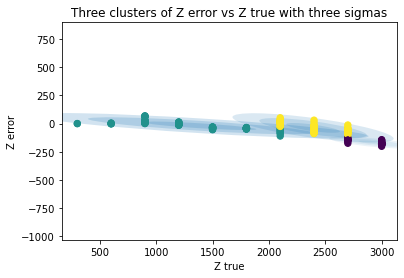

In [12]:
z_true_and_z_error = get_columns(data, [3, 6])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z true")
ax.set_ylabel("Z error")
ax.set_title("Three clusters of Z error vs Z true with three sigmas")
        
gmm = GaussianMixture(n_components=3, random_state=3)
plot_gmm(gmm, z_true_and_z_error, ax)
plt.show()

In order to illustrate the usefulness of the GMM, samples are drawn and graphed from the previous three cluster fit.

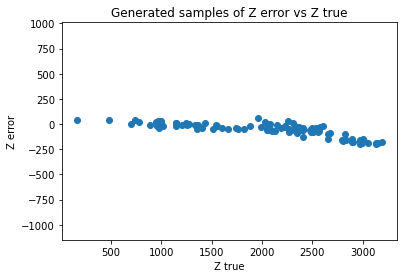

In [13]:
z_true_and_z_error_new, labels = gmm.sample(100)
ax = plt.gca()
ax.set_xlabel("Z true")
ax.set_ylabel("Z error")
ax.set_title("Generated samples of Z error vs Z true")
ax.scatter(z_true_and_z_error_new[:, 0], z_true_and_z_error_new[:, 1])
ax.axis("equal")
plt.show()

Also, by adding the noise to the ground truth, realistic samples of Z measured can be created (Z measured = Z true + Z error).

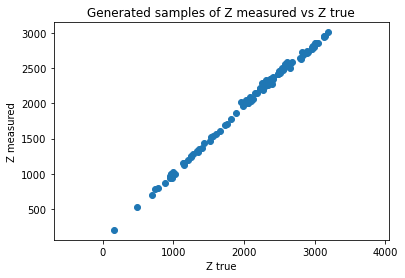

In [14]:
z_measured = z_true_and_z_error_new[:, 0] + z_true_and_z_error_new[:, 1]
ax = plt.gca()
ax.axis("equal")
ax.set_xlabel("Z true")
ax.set_ylabel("Z measured")
ax.set_title("Generated samples of Z measured vs Z true")
ax.scatter(z_true_and_z_error_new[:, 0], z_measured)
plt.show()

## Additional analysis

Here's pretty much the same analysis as before, but this time using the measured values as a base.

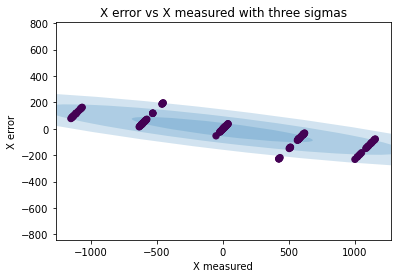

In [15]:
x_measured_and_x_error = get_columns(data, [0, 4])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("X measured")
ax.set_ylabel("X error")
ax.set_title("X error vs X measured with three sigmas")
        
gmm = GaussianMixture(n_components=1, random_state=1)
plot_gmm(gmm, x_measured_and_x_error, ax)
plt.show()

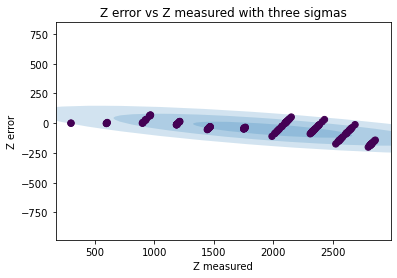

In [20]:
z_measured_and_z_error = get_columns(data, [2, 6])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z measured")
ax.set_ylabel("Z error")
ax.set_title("Z error vs Z measured with three sigmas")
        
gmm = GaussianMixture(n_components=1, random_state=1)
plot_gmm(gmm, z_measured_and_z_error, ax)
plt.show()

[[ 3.00500000e+02  5.00000000e-01]
 [ 6.01000000e+02  1.00000000e+00]
 [ 9.34187500e+02  3.41875000e+01]
 [ 1.19681250e+03 -3.18750000e+00]
 [ 1.46143750e+03 -3.85625000e+01]
 [ 1.75818750e+03 -4.18125000e+01]
 [ 2.08758621e+03 -1.24137950e+01]
 [ 2.34829229e+03 -5.17077143e+01]
 [ 2.60553181e+03 -9.44002274e+01]
 [ 2.82544446e+03 -1.74555543e+02]]
[2.50001000e-01 8.80000100e+00 6.52652345e+02 9.74023447e+01
 5.64960947e+01 1.54023447e+01 1.76638058e+03 8.52844098e+02
 1.88094769e+03 1.70765130e+02]


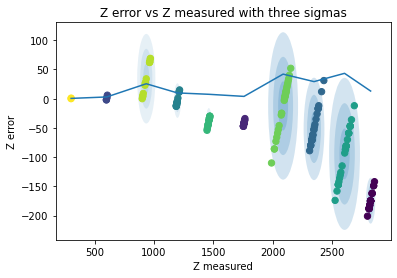

In [75]:
z_measured_and_z_error = get_columns(data, [2, 6])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z measured")
ax.set_ylabel("Z error")
ax.set_title("Z error vs Z measured with three sigmas")
        
gmm = GaussianMixture(n_components=10, random_state=1, covariance_type="diag")
plot_gmm(gmm, z_measured_and_z_error, ax)
ax.axis("auto")

means = gmm.means_
covariances = gmm.covariances_
sorted_indices = np.argsort(means, axis=0)[:,0]

print(means[sorted_indices])
print(covariances[sorted_indices, 1])

ax.plot(means[sorted_indices, 0], np.sqrt(covariances[sorted_indices, 1]))
plt.show()

[[   0.         -145.18789402]
 [   0.            5.06572141]
 [   0.          -44.93762717]
 [   0.           62.86103445]
 [   0.          -73.34963845]
 [   0.          -32.48721022]
 [   0.         -186.96337971]
 [   0.           28.61668016]
 [   0.          -11.80421814]
 [   0.         -175.        ]]
[2.88602298e+02 4.33344419e+01 3.46324722e+01 2.63862283e+01
 1.04810596e+02 2.55744605e+01 3.62977766e+01 3.24277140e+01
 1.30826283e+01 9.99996362e-07]


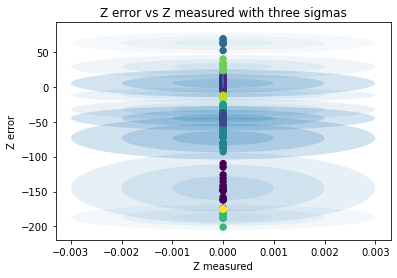

In [86]:
z_error = get_columns(data, [2, 6])
z_error[:, 0] = np.zeros(np.shape(z_error)[0])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z measured")
ax.set_ylabel("Z error")
ax.set_title("Z error vs Z measured with three sigmas")
        
gmm = GaussianMixture(n_components=10, random_state=1, covariance_type="diag")
plot_gmm(gmm, z_error, ax)
ax.axis("auto")

means = gmm.means_
covariances = gmm.covariances_
sorted_indices = np.argsort(means, axis=0)[:,0]

print(means[sorted_indices])
print(covariances[sorted_indices, 1])

ax.plot(means[sorted_indices, 0], np.sqrt(covariances[sorted_indices, 1]))
plt.show()

[[ 3.00000000e-01  5.00000000e-04]
 [ 6.00000000e-01  1.00000000e-03]
 [ 9.00000000e-01  3.41875000e-02]
 [ 1.20000000e+00 -3.18750000e-03]
 [ 1.50000000e+00 -3.85625000e-02]
 [ 1.80000000e+00 -4.18125000e-02]
 [ 2.10000000e+00 -1.24137931e-02]
 [ 2.40000000e+00 -5.16896552e-02]
 [ 2.70000000e+00 -9.44285714e-02]
 [ 3.00000000e+00 -1.74555556e-01]]
[1.25000000e-06 9.80000000e-06 6.53652344e-04 9.84023437e-05
 5.74960937e-05 1.64023438e-05 1.76738050e-03 8.55145065e-04
 1.87881633e-03 1.71765432e-04]
[0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]
0.0012233665539556002


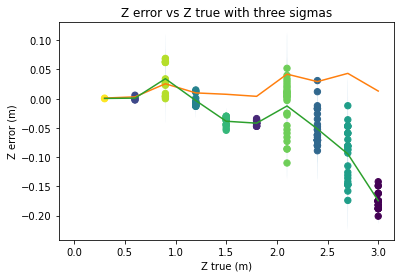

In [337]:
z_true_and_z_error = get_columns(data, [3, 6]) / 1000

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z true (m)")
ax.set_ylabel("Z error (m)")
ax.set_title("Z error vs Z true with three sigmas")
        
gmm = GaussianMixture(n_components=10, random_state=1, covariance_type="diag")
plot_gmm(gmm, z_true_and_z_error, ax)
ax.axis("auto")

means = gmm.means_
covariances = gmm.covariances_
sorted_indices = np.argsort(means, axis=0)[:,0]

print(means[sorted_indices])
print(covariances[sorted_indices, 1])

from sklearn import linear_model
reg = linear_model.LinearRegression()
new_array = np.zeros((np.shape(means)[0], 2))
print(means[sorted_indices, 0])
model = reg.fit(means[sorted_indices, 0].reshape(-1, 1), np.sqrt(covariances[sorted_indices, 1]))
x = np.arange(0, 3, 10)
prediction = reg.predict(x.reshape(-1, 1))
ax.plot(x, prediction)
print(prediction[-1])

ax.plot(means[sorted_indices, 0], np.sqrt(covariances[sorted_indices, 1]))
ax.plot(means[sorted_indices, 0], means[sorted_indices, 1])
plt.show()

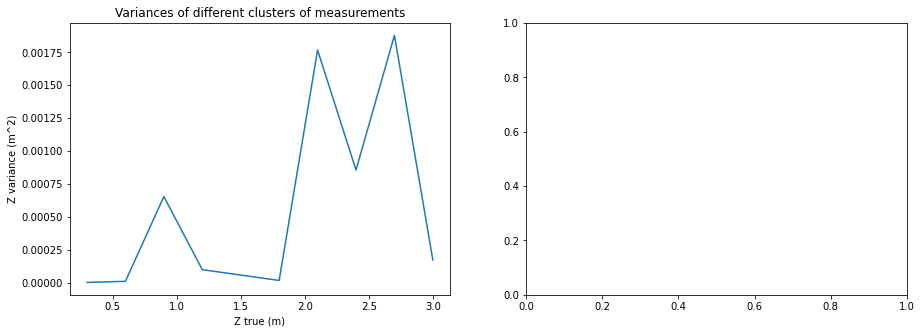

In [332]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15,5))
ax_1.set_xlabel("Z true (m)")
ax_1.set_ylabel("Z variance (m^2)")
ax_1.set_title("Variances of different clusters of measurements")
ax_1.plot(means[sorted_indices, 0], covariances[sorted_indices, 1])
plt.show()

### Z error

(28, 2)
Mean and standard deviation: -0.0944285714285714 0.04333377812435251


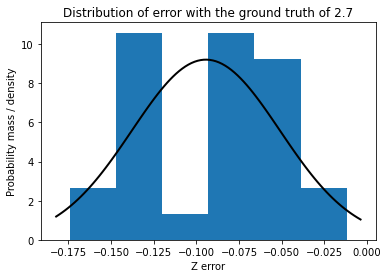

In [317]:
measurements = get_columns(data, [3, 6]) / 1000
# values_selected = [300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000]
values_selected = [2.700]
filtered_array = measurements[np.isin(measurements[:, 0], values_selected)]
print(np.shape(filtered_array))

bins = "auto"
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z error")
ax.set_ylabel("Probability mass / density")
ax.set_title("Distribution of error with the ground truth of " + str(values_selected).strip("[]"))
ax.hist(filtered_array[:, 1], bins=bins, density=True)

mean, std_dev = norm.fit(filtered_array[:, 1])
print("Mean and standard deviation:", mean, std_dev)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
ax.plot(x, p, 'k', linewidth=2)

plt.show()

### X error

(184, 2)
Mean and standard deviation: -5.619565217391305 95.48387553282222


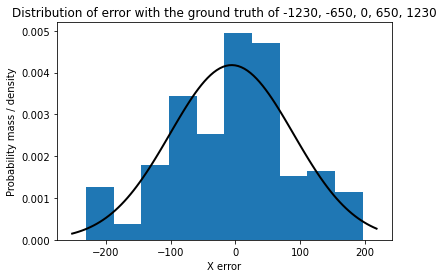

In [251]:
measurements = get_columns(data, [1, 4])
values_selected = [-1230, -650, 0, 650, 1230]
filtered_array = measurements[np.isin(measurements[:, 0], values_selected)]
print(np.shape(filtered_array))

bins = "auto"
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("X error")
ax.set_ylabel("Probability mass / density")
ax.set_title("Distribution of error with the ground truth of " + str(values_selected).strip("[]"))
ax.hist(filtered_array[:, 1], bins=bins, density=True)

mean, std_dev = norm.fit(filtered_array[:, 1])
print("Mean and standard deviation:", mean, std_dev)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
ax.plot(x, p, 'k', linewidth=2)

plt.show()

## New idea: combined measurements

First of all, reading in the new measurements:

In [523]:
with open("measurements_combined.csv") as csvfile:
    csv_reader = csv.reader(csvfile, csv.QUOTE_MINIMAL, delimiter=",")
    next(csv_reader)  # skip the header row
    rows = []
    
    for row in csv_reader:
        rows.append([row[2], row[3], row[6], row[7]])
    
data_combined = np.asarray(rows, dtype=np.int)
# print(data_combined)

Trying to find normal distributions in with the histograms.

Nr of measurements: 10
Mean and standard deviation: 19.2 19.523319389898838


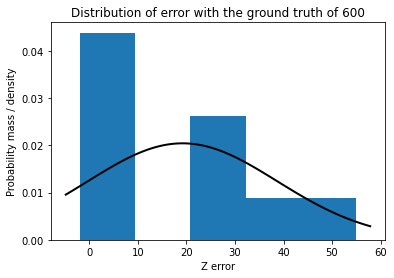

In [524]:
measurements = get_columns(data_combined, [1, 2])
values_selected = [300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000]
values_selected = [600]
filtered_array = measurements[np.isin(measurements[:, 0], values_selected)]
print("Nr of measurements:", np.shape(filtered_array)[0])

bins = "auto"
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z error")
ax.set_ylabel("Probability mass / density")
ax.set_title("Distribution of error with the ground truth of " + str(values_selected).strip("[]"))
ax.hist(filtered_array[:, 1], bins=bins, density=True)

mean, std_dev = norm.fit(filtered_array[:, 1])
print("Mean and standard deviation:", mean, std_dev)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
ax.plot(x, p, 'k', linewidth=2)

plt.show()

In [525]:
def find_means(ground_truth_and_error, ground_truth_values):
    means = np.zeros(len(ground_truth_values))
    for i, value in enumerate(ground_truth_values):
        filtered_array = ground_truth_and_error[np.isin(ground_truth_and_error[:, 0], [value])]
        values = filtered_array[:, 1]
        # print(values, np.var(values))
        means[i] = np.mean(values)
    return means

def find_variances(ground_truth_and_error, ground_truth_values):
    variances = np.zeros(len(ground_truth_values))
    for i, value in enumerate(ground_truth_values):
        filtered_array = ground_truth_and_error[np.isin(ground_truth_and_error[:, 0], [value])]
        values = filtered_array[:, 1]
        # print(values, np.var(values))
        variances[i] = np.var(values)
    return variances
        
def find_rms(ground_truth_and_error, ground_truth_values):
    rms = np.zeros(len(values_selected))
    for i, value in enumerate(ground_truth_values):
        filtered_array = ground_truth_and_error[np.isin(ground_truth_and_error[:, 0], [value])]
        values = filtered_array[:, 1]
        # print(values, np.var(values))
        rms[i] = np.sqrt(np.mean(values ** 2))
    return rms

## RMS and variance of the clusters of Z

[0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]


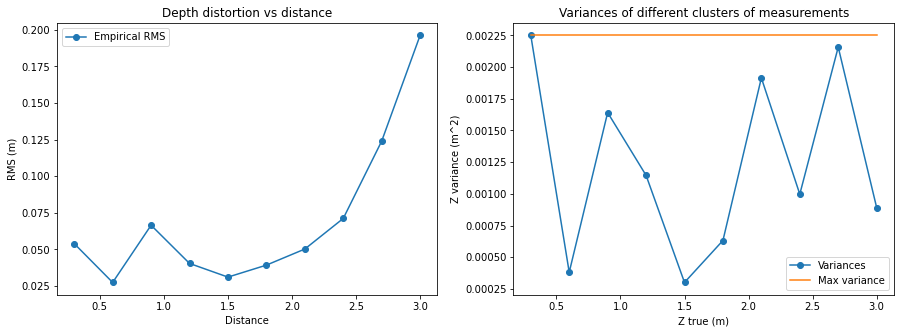

Maximum variance: 0.002 m^2
Maximum one standard deviation: 0.047 m


In [579]:
measurements = get_columns(data_combined, [1, 2])
values_selected = np.asarray([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0])
measurements_m = measurements / 1000  # converting mm to m
print(values_selected)

rms = find_rms(measurements_m, values_selected)
variances = find_variances(measurements_m, values_selected)
    
# Finding the maximum variance
max_variance = np.max(variances)

# Plotting
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15,5))
    
ax_1.set_xlabel("Distance")
ax_1.set_ylabel("RMS (m)")
ax_1.set_title("Depth distortion vs distance")
ax_1.plot(values_selected, rms, "o-", label="Empirical RMS")
ax_1.legend()

ax_2.set_xlabel("Z true (m)")
ax_2.set_ylabel("Z variance (m^2)")
ax_2.set_title("Variances of different clusters of measurements")
ax_2.plot(values_selected, variances, "o-", label="Variances")
ax_2.plot(values_selected, np.full(len(values_selected), max_variance), label="Max variance")
ax_2.legend()
plt.show()

print("Maximum variance: " + str(round(max_variance, 3)) + " m^2")
print("Maximum one standard deviation: " + str(round(np.sqrt(max_variance), 3)) + " m")

# print(rms)
# print(variances)

[0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]
[ 0.02558333  0.0192      0.05270588  0.022      -0.02573529 -0.03010811
 -0.0246087  -0.06371111 -0.11488889 -0.19391667]
[0.04744024 0.01952332 0.04051255 0.03384828 0.01734309 0.02513508
 0.04375648 0.03158032 0.04645199 0.02985788]
[-0.04036923  0.0596749   0.00806784] [[ 0.00010261 -0.0003386   0.00020316]
 [-0.0003386   0.00117648 -0.00076794]
 [ 0.00020316 -0.00076794  0.00060704]]


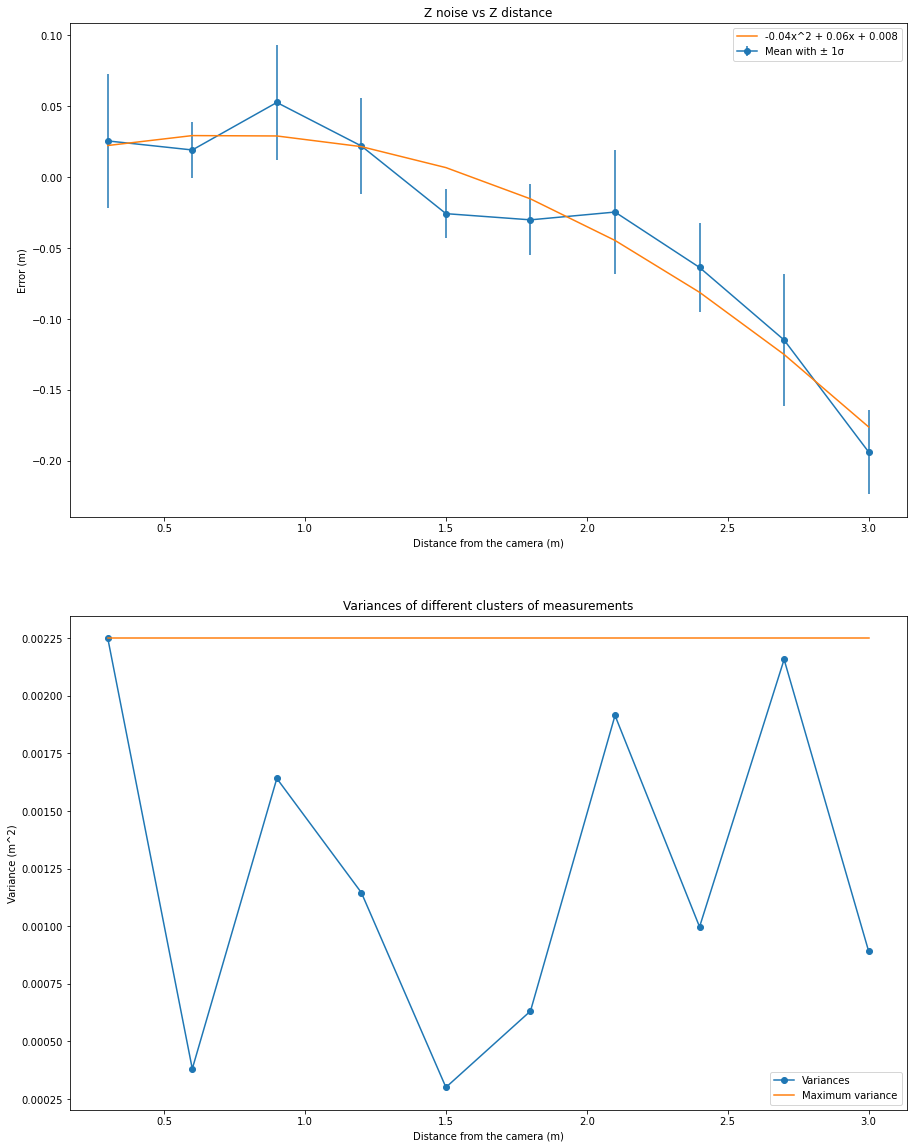

Maximum variance: 0.00225 m^2
Maximum one standard deviation: 0.0474 m


In [581]:
measurements = get_columns(data_combined, [1, 2])
values_selected = np.asarray([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0])
measurements_m = measurements / 1000  # converting mm to m
print(values_selected)

means = find_means(measurements_m, values_selected)
rms = find_rms(measurements_m, values_selected)
variances = find_variances(measurements_m, values_selected)

print(means)
print(np.sqrt(variances))

def func(x, a, b, c):
    return a * x ** 2 + b * x + c

# Curve fitting
popt, pcov = curve_fit(func, values_selected, means)
popt_ = [round(x, 3) for x in popt]
formula = str(popt_[0]) + "x^2 + " + str(popt_[1]) + "x + " + str(popt_[2])
print(popt, pcov)
    
# Finding the maximum variance
max_variance = np.max(variances)

# Plotting
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15,20))

ax_1.set_xlabel("Distance from the camera (m)")
ax_1.set_ylabel("Error (m)")
ax_1.set_title("Z noise vs Z distance")
ax_1.errorbar(values_selected, means, yerr=np.sqrt(variances), fmt="o-", barsabove=True, label="Mean with ± 1σ")
ax_1.plot(values_selected, func(values_selected, *popt), label=formula)
ax_1.legend()

ax_2.set_xlabel("Distance from the camera (m)")
ax_2.set_ylabel("Variance (m^2)")
ax_2.set_title("Variances of different clusters of measurements")
ax_2.plot(values_selected, variances, "o-", label="Variances")
ax_2.plot(values_selected, np.full(len(values_selected), max_variance), label="Maximum variance")
ax_2.legend(loc="lower right")

#ax_1.axis("equal")

plt.show()

print("Maximum variance: " + str(round(max_variance, 5)) + " m^2")
print("Maximum one standard deviation: " + str(round(np.sqrt(max_variance), 4)) + " m")

# print(rms)
# print(variances)

## Variances of the clusters of X

[-1.23 -0.65  0.    0.65  1.23]
[7.87933884e-05 2.08465278e-04 3.12107750e-04 3.17276735e-04
 1.67818182e-04]
[ 0.09245455  0.04441667  0.0066087  -0.06125714 -0.095     ]
[-0.07731143 -0.00255545] [[1.49110923e-05 2.96138371e-21]
 [2.96138371e-21 1.15435716e-05]]


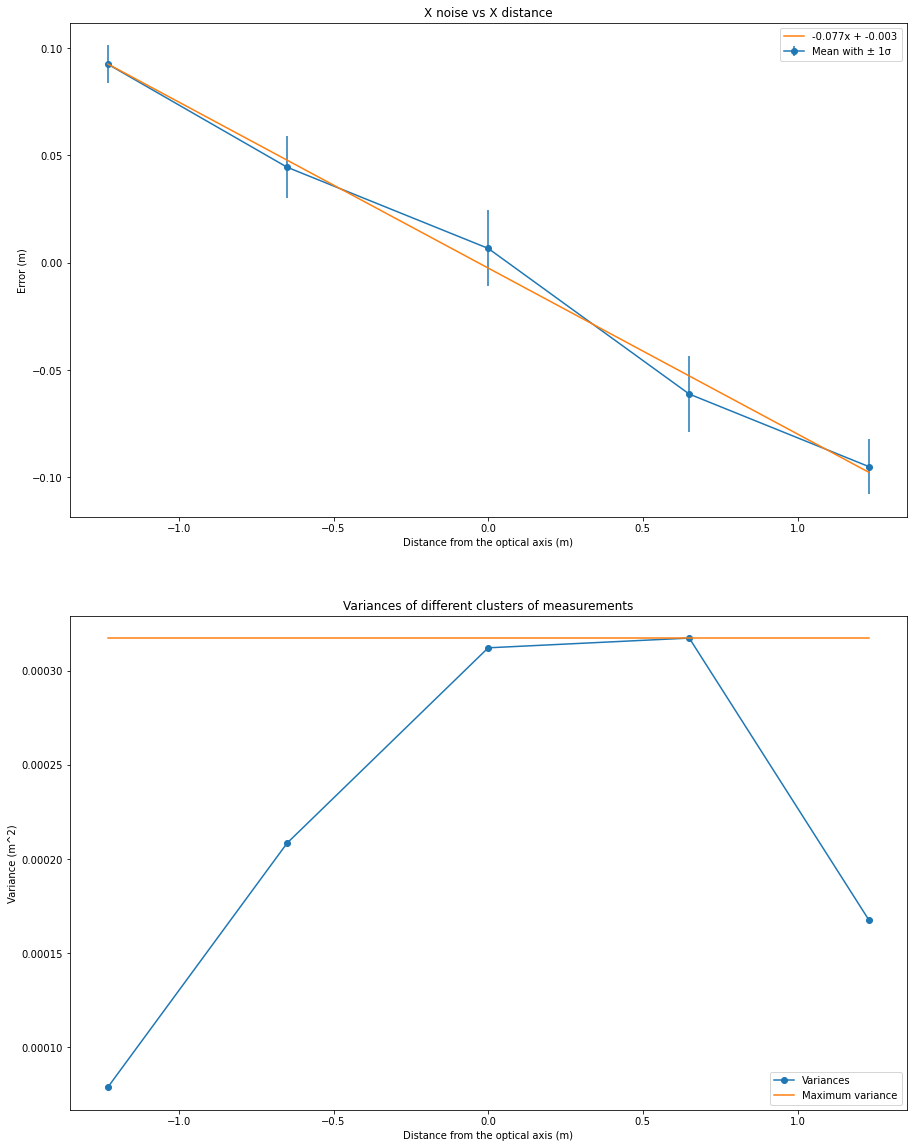

Maximum variance: 0.00032 m^2
Maximum one standard deviation: 0.018 m


In [578]:
measurements = get_columns(data, [1, 4])
values_selected = np.asarray([-1.230, -0.650, 0.000, 0.650, 1.230])
measurements_m = measurements / 1000  # converting mm to m
print(values_selected)

rms = find_rms(measurements_m, values_selected)
variances = find_variances(measurements_m, values_selected)
print(variances)
means = find_means(measurements_m, values_selected)
print(means)

def func(x, a, b):
    return a * x  + b

# Curve fitting
popt, pcov = curve_fit(func, values_selected, means)
popt_ = [round(x, 3) for x in popt]
formula = str(popt_[0]) + "x + " + str(popt_[1])
print(popt, pcov)
    
# Finding the maximum variance
max_variance = np.max(variances)

# Plotting
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15,20))

ax_1.set_xlabel("Distance from the optical axis (m)")
ax_1.set_ylabel("Error (m)")
ax_1.set_title("X noise vs X distance")
ax_1.errorbar(values_selected, means, yerr=np.sqrt(variances), fmt="o-", barsabove=True, label="Mean with ± 1σ")
ax_1.plot(values_selected, func(values_selected, *popt), label=formula)
ax_1.legend()

ax_2.set_xlabel("Distance from the optical axis (m)")
ax_2.set_ylabel("Variance (m^2)")
ax_2.set_title("Variances of different clusters of measurements")
ax_2.plot(values_selected, variances, "o-", label="Variances")
ax_2.plot(values_selected, np.full(len(values_selected), max_variance), label="Maximum variance")
ax_2.legend()
plt.show()

print("Maximum variance: " + str(round(max_variance, 5)) + " m^2")
print("Maximum one standard deviation: " + str(round(np.sqrt(max_variance), 3)) + " m")

# print(rms)
# print(variances)

## X error vs Z distance

[0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]
[0.00000000e+00 6.96000000e-06 2.95990898e-02 1.07420898e-02
 2.81405859e-03 1.01621484e-03 1.44092675e-02 8.00828300e-03
 5.20367347e-03 6.04797805e-03]
[-0.007       0.0142      0.0043125  -0.0213125  -0.0090625   0.0023125
 -0.0127931  -0.00168966 -0.00957143 -0.00085185]


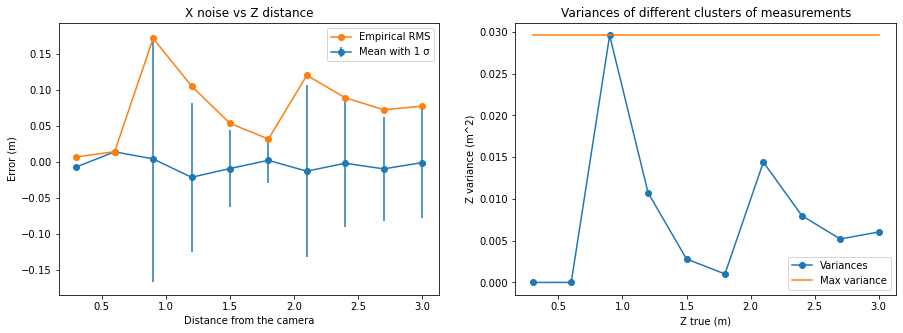

Maximum variance: 0.03 m^2
Maximum one standard deviation: 0.172 m


In [451]:
measurements = get_columns(data, [3, 4])
values_selected = np.asarray([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0])
measurements_m = measurements / 1000  # converting mm to m
print(values_selected)

rms = find_rms(measurements_m, values_selected)
variances = find_variances(measurements_m, values_selected)
print(variances)
means = find_means(measurements_m, values_selected)
print(means)
    
# Finding the maximum variance
max_variance = np.max(variances)

# Plotting
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15,5))

ax_1.set_xlabel("Distance from the camera")
ax_1.set_ylabel("Error (m)")
ax_1.set_title("X noise vs Z distance")
ax_1.errorbar(values_selected, means, yerr=np.sqrt(variances), fmt="o-", barsabove=True, label="Mean with 1 σ")
ax_1.plot(values_selected, rms, "o-", label="Empirical RMS")
ax_1.legend()

ax_2.set_xlabel("Z true (m)")
ax_2.set_ylabel("Z variance (m^2)")
ax_2.set_title("Variances of different clusters of measurements")
ax_2.plot(values_selected, variances, "o-", label="Variances")
ax_2.plot(values_selected, np.full(len(values_selected), max_variance), label="Max variance")
ax_2.legend()
plt.show()

print("Maximum variance: " + str(round(max_variance, 3)) + " m^2")
print("Maximum one standard deviation: " + str(round(np.sqrt(max_variance), 3)) + " m")

# print(rms)
# print(variances)

## Filtered out the detections where the human was partially out of the frame

In [481]:
with open("measurements_without_edges.csv") as csvfile:
    csv_reader = csv.reader(csvfile, csv.QUOTE_MINIMAL, delimiter=",")
    next(csv_reader)  # skip the header row
    rows = []
    for row in csv_reader:
        rows.append(row)
    
data_without_edges = np.asarray(rows, dtype=np.int)

## Variances of the clusters of X

[-1.23 -0.65  0.    0.65  1.23]
Var: [7.87933884e-05 2.08465278e-04 3.12107750e-04 3.17276735e-04
 1.67818182e-04]
Std: [0.00887656 0.01443833 0.01766657 0.01781226 0.01295447]
Mean: [ 0.09245455  0.04441667  0.0066087  -0.06125714 -0.095     ]


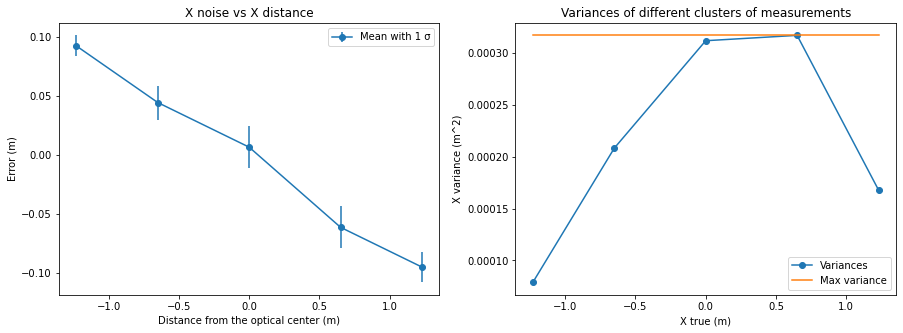

Maximum variance: 0.00032 m^2
Maximum one standard deviation: 0.018 m


In [566]:
measurements = get_columns(data_without_edges, [1, 4])
values_selected = np.asarray([-1.230, -0.650, 0.000, 0.650, 1.230])
measurements_m = measurements / 1000  # converting mm to m
print(values_selected)

rms = find_rms(measurements_m, values_selected)
variances = find_variances(measurements_m, values_selected)
print("Var:", variances)
print("Std:", np.sqrt(variances))
means = find_means(measurements_m, values_selected)
print("Mean:", means)
    
# Finding the maximum variance
max_variance = np.max(variances)

# Plotting
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15,5))

ax_1.set_xlabel("Distance from the optical center (m)")
ax_1.set_ylabel("Error (m)")
ax_1.set_title("X noise vs X distance")
ax_1.errorbar(values_selected, means, yerr=np.sqrt(variances), fmt="o-", barsabove=True, label="Mean with 1 σ")
ax_1.legend()

ax_2.set_xlabel("X true (m)")
ax_2.set_ylabel("X variance (m^2)")
ax_2.set_title("Variances of different clusters of measurements")
ax_2.plot(values_selected, variances, "o-", label="Variances")
ax_2.plot(values_selected, np.full(len(values_selected), max_variance), label="Max variance")
ax_2.legend()
plt.show()

print("Maximum variance: " + str(round(max_variance, 5)) + " m^2")
print("Maximum one standard deviation: " + str(round(np.sqrt(max_variance), 3)) + " m")

# print(rms)
# print(variances)

[0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]
[0.00000000e+00 6.96000000e-06 5.20000000e-06 7.55555556e-06
 2.81405859e-03 1.01621484e-03 1.46973702e-03 1.86377855e-03
 5.20367347e-03 6.04797805e-03]
[-0.007       0.0142      0.008       0.00766667 -0.0090625   0.0023125
 -0.00429412  0.00352941 -0.00957143 -0.00085185]


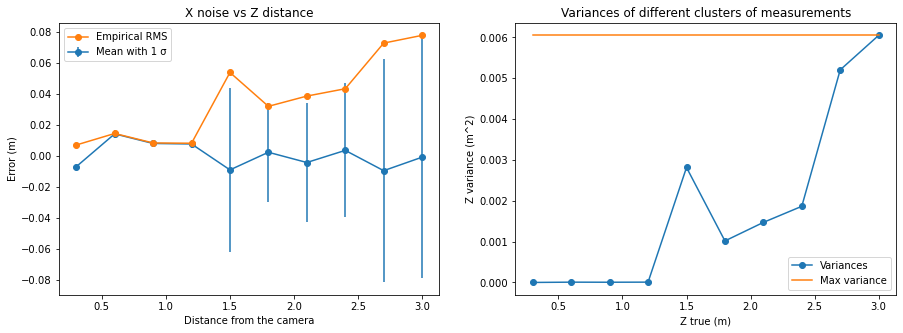

Maximum variance: 0.006 m^2
Maximum one standard deviation: 0.078 m


In [483]:
measurements = get_columns(data, [3, 4])
values_selected = np.asarray([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0])
measurements_m = measurements / 1000  # converting mm to m
print(values_selected)

rms = find_rms(measurements_m, values_selected)
variances = find_variances(measurements_m, values_selected)
print(variances)
means = find_means(measurements_m, values_selected)
print(means)
    
# Finding the maximum variance
max_variance = np.max(variances)

# Plotting
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15,5))

ax_1.set_xlabel("Distance from the camera")
ax_1.set_ylabel("Error (m)")
ax_1.set_title("X noise vs Z distance")
ax_1.errorbar(values_selected, means, yerr=np.sqrt(variances), fmt="o-", barsabove=True, label="Mean with 1 σ")
ax_1.plot(values_selected, rms, "o-", label="Empirical RMS")
ax_1.legend()

ax_2.set_xlabel("Z true (m)")
ax_2.set_ylabel("Z variance (m^2)")
ax_2.set_title("Variances of different clusters of measurements")
ax_2.plot(values_selected, variances, "o-", label="Variances")
ax_2.plot(values_selected, np.full(len(values_selected), max_variance), label="Max variance")
ax_2.legend()
plt.show()

print("Maximum variance: " + str(round(max_variance, 3)) + " m^2")
print("Maximum one standard deviation: " + str(round(np.sqrt(max_variance), 3)) + " m")

# print(rms)
# print(variances)

0.39274348153633504 0.9150222369552288
0.7071065626602183
0.8660252109488276


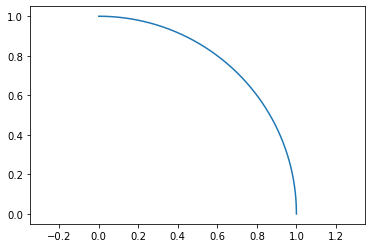

In [519]:
sample_range = np.linspace(0, np.pi / 2, 1000)
sample_sine = np.sin(sample_range)

sample_range_2 = np.linspace(0, 1, 1000)
sample_circle = np.sqrt(1 - sample_range_2 ** 2)

total_area = 0
for i, sample in enumerate(sample_circle):
    total_area += sample * 0.001
    if total_area >= np.pi / 8:
        break

print(total_area, sample)
print(np.median(sample_sine))
print(np.median(sample_circle))

fig, ax = plt.subplots(1, 1)
#ax.plot(sample_range, np.flip(sample_sine))
ax.plot(sample_range_2, sample_circle)
#ax.plot(sample_range_2, np.full(len(sample_range_2), 0.9150222369552288))
#ax.plot(np.full(len(sample_range_2), sample_range_2[i]), sample_range_2)
ax.axis("equal")
plt.show()

## Theoretical vs empirical RMS

[0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]
465.60288917518244
[0.00030928 0.00123711 0.00278349 0.00494842 0.00773191 0.01113395
 0.01515455 0.01979369 0.02505139 0.03092764]
[ 0.09678398 -0.33068426  0.31394671] [[ 0.0001622  -0.00072989  0.00077855]
 [-0.00072989  0.00331567 -0.00357356]
 [ 0.00077855 -0.00357356  0.00390289]]


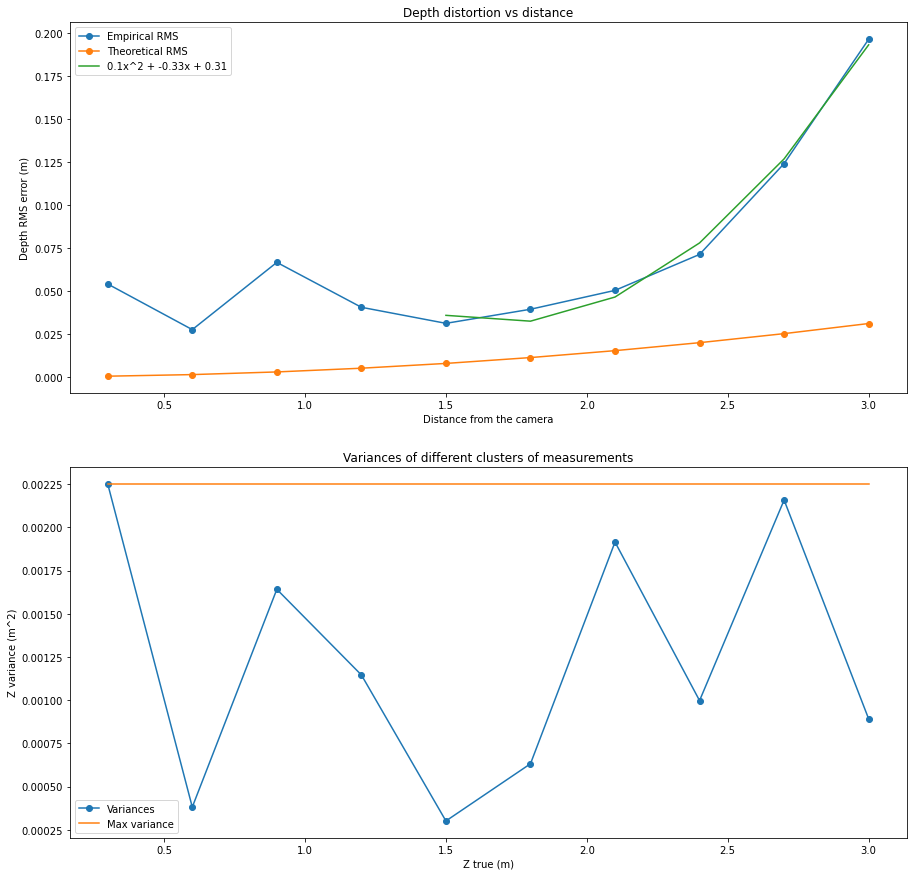

Maximum variance: 0.002 m^2
Maximum one standard deviation: 0.047 m


In [565]:
measurements = get_columns(data_combined, [1, 2])
values_selected = np.asarray([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0])
measurements_m = measurements / 1000  # converting mm to m
print(values_selected)

# Empirical RMS
rms = find_rms(measurements_m, values_selected)
variances = find_variances(measurements_m, values_selected)

# Theoretical RMS
fov_h = 69  # degrees
f = 0.5 * 640 / np.tan(np.radians(fov_h / 2))
print(f)
def rms_error_function(d, f=465.60288917518244, s = 0.08, b = 0.05):
    return (d ** 2 * s) / (f * b)

rms_theoretical = np.asarray(list(map(rms_error_function, values_selected)))
print(rms_theoretical)

# Curve fitting 
def func(x, a, b, c):
    return a * x ** 2 + b * x + c

popt, pcov = curve_fit(func, values_selected[4:], rms[4:])
popt_ = [round(x, 2) for x in popt]
formula = str(popt_[0]) + "x^2 + " + str(popt_[1]) + "x + " + str(popt_[2])
print(popt, pcov)
fitted_values = func(values_selected, *popt)
# fitted_values[:4] = 0.04
    
# Finding the maximum variance
max_variance = np.max(variances)

# Plotting
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15,15))
    
ax_1.set_xlabel("Distance from the camera")
ax_1.set_ylabel("Depth RMS error (m)")
ax_1.set_title("Depth distortion vs distance")
ax_1.plot(values_selected, rms, "o-", label="Empirical RMS")
ax_1.plot(values_selected, rms_theoretical, "o-", label="Theoretical RMS")
ax_1.plot(values_selected[4:], fitted_values[4:], label=formula)
ax_1.legend()

ax_2.set_xlabel("Z true (m)")
ax_2.set_ylabel("Z variance (m^2)")
ax_2.set_title("Variances of different clusters of measurements")
ax_2.plot(values_selected, variances, "o-", label="Variances")
ax_2.plot(values_selected, np.full(len(values_selected), max_variance), label="Max variance")
ax_2.legend()
plt.show()

print("Maximum variance: " + str(round(max_variance, 3)) + " m^2")
print("Maximum one standard deviation: " + str(round(np.sqrt(max_variance), 3)) + " m")

# print(rms)
# print(variances)